Training LSTM model on 1500 seeds...
        S   E   I     R      Beta
0    9950   0  50     0  0.000010
1    9945   5  45     5  0.000007
2    9942   8  41     9  0.000017
3    9935  13  39    13  0.000013
4    9930  16  39    15  0.000028
..    ...  ..  ..   ...       ...
246  6099  17  23  3861  0.000007
247  6098  17  21  3864  0.000000
248  6098  12  24  3866  0.000000
249  6098  12  21  3869  0.000016
250  6096  14  21  3869       NaN

[251 rows x 5 columns]
[[ 0.00000000e+00  9.95000000e+03  0.00000000e+00 ...  0.00000000e+00
   4.10000000e+01 -1.15079129e+01]
 [ 1.00000000e+00  9.94500000e+03  5.00000000e+00 ...  5.00000000e+00
   3.90000000e+01 -1.19128754e+01]
 [ 2.00000000e+00  9.94200000e+03  8.00000000e+00 ...  9.00000000e+00
   3.90000000e+01 -1.09721854e+01]
 ...
 [ 2.48000000e+02  6.09800000e+03  1.20000000e+01 ...  3.86600000e+03
   2.10000000e+01 -1.61180957e+01]
 [ 2.49000000e+02  6.09800000e+03  1.20000000e+01 ...  3.86900000e+03
   0.00000000e+00 -1.10670914e+01]
 

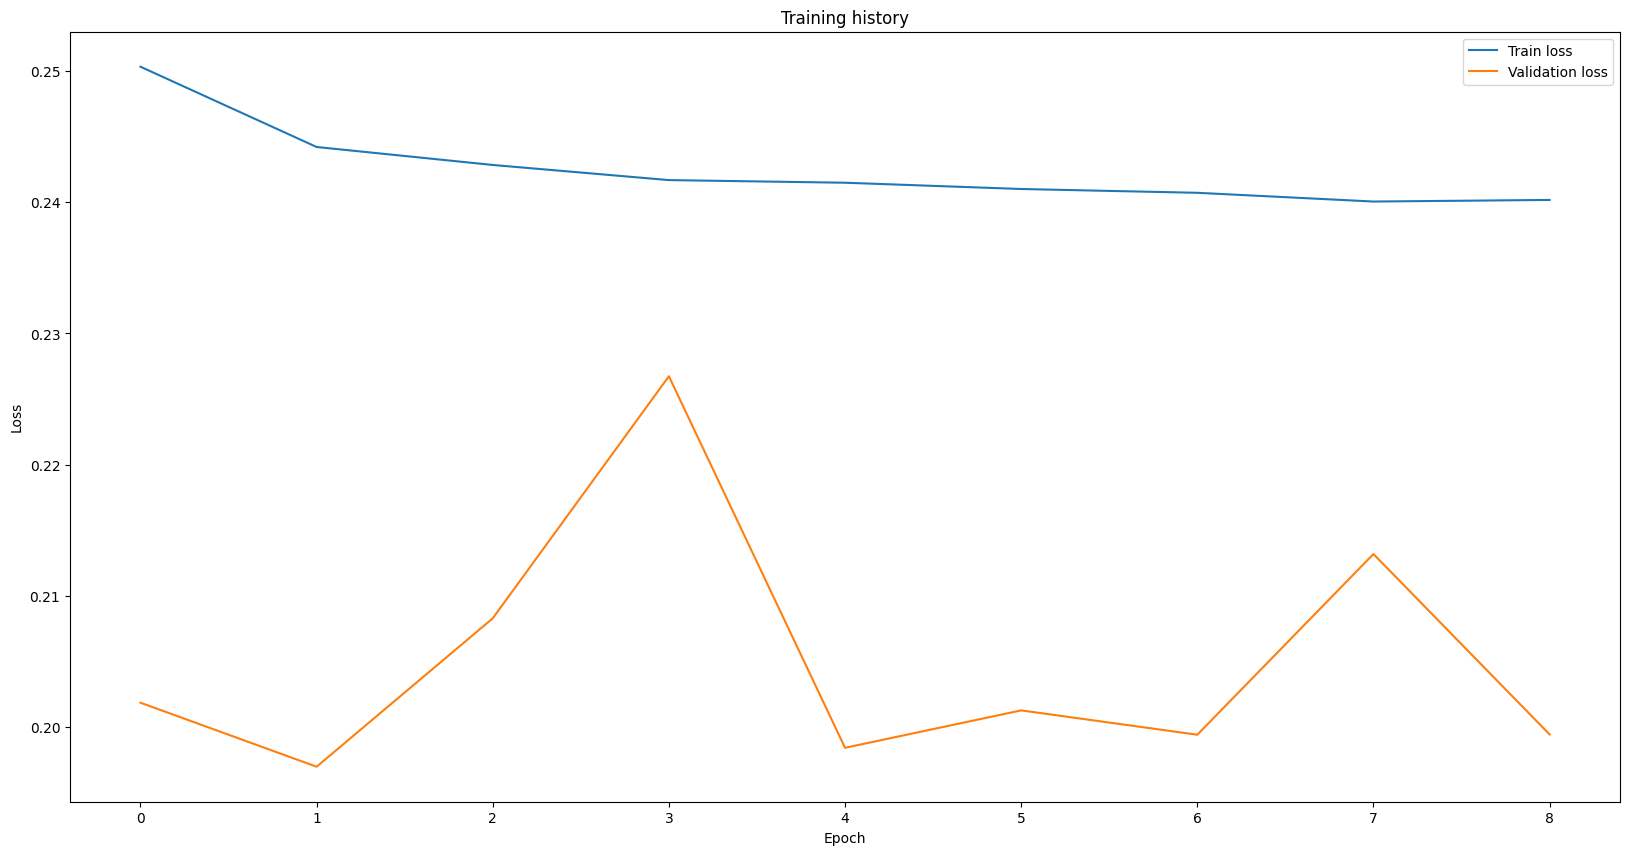

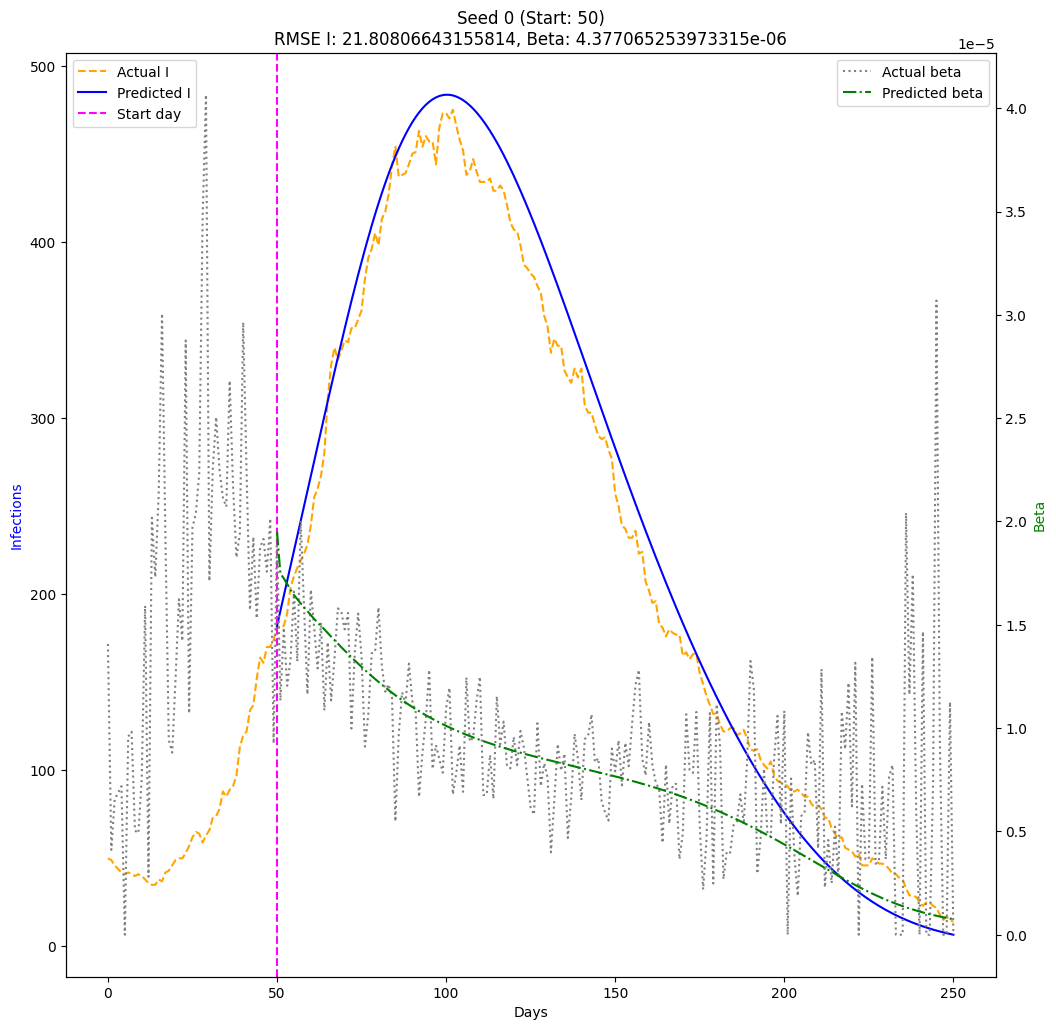

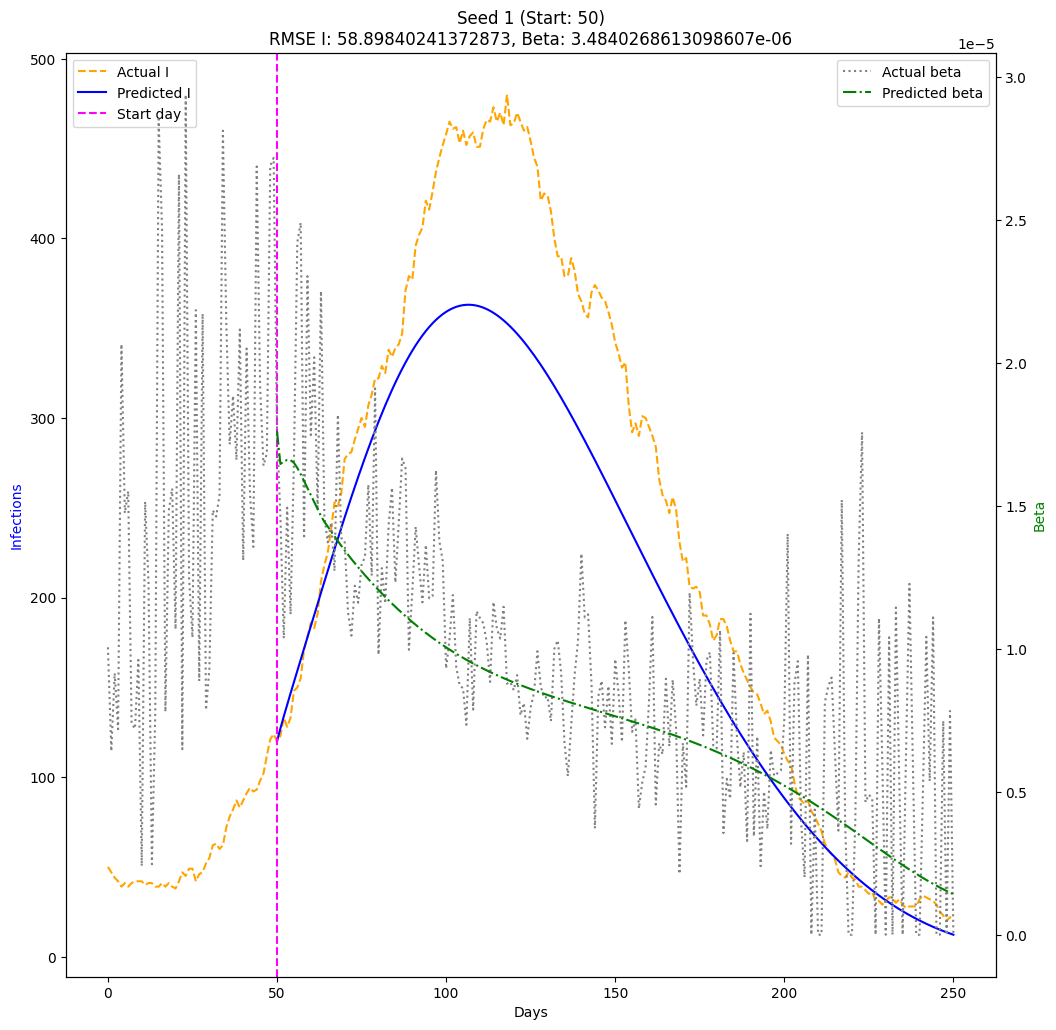

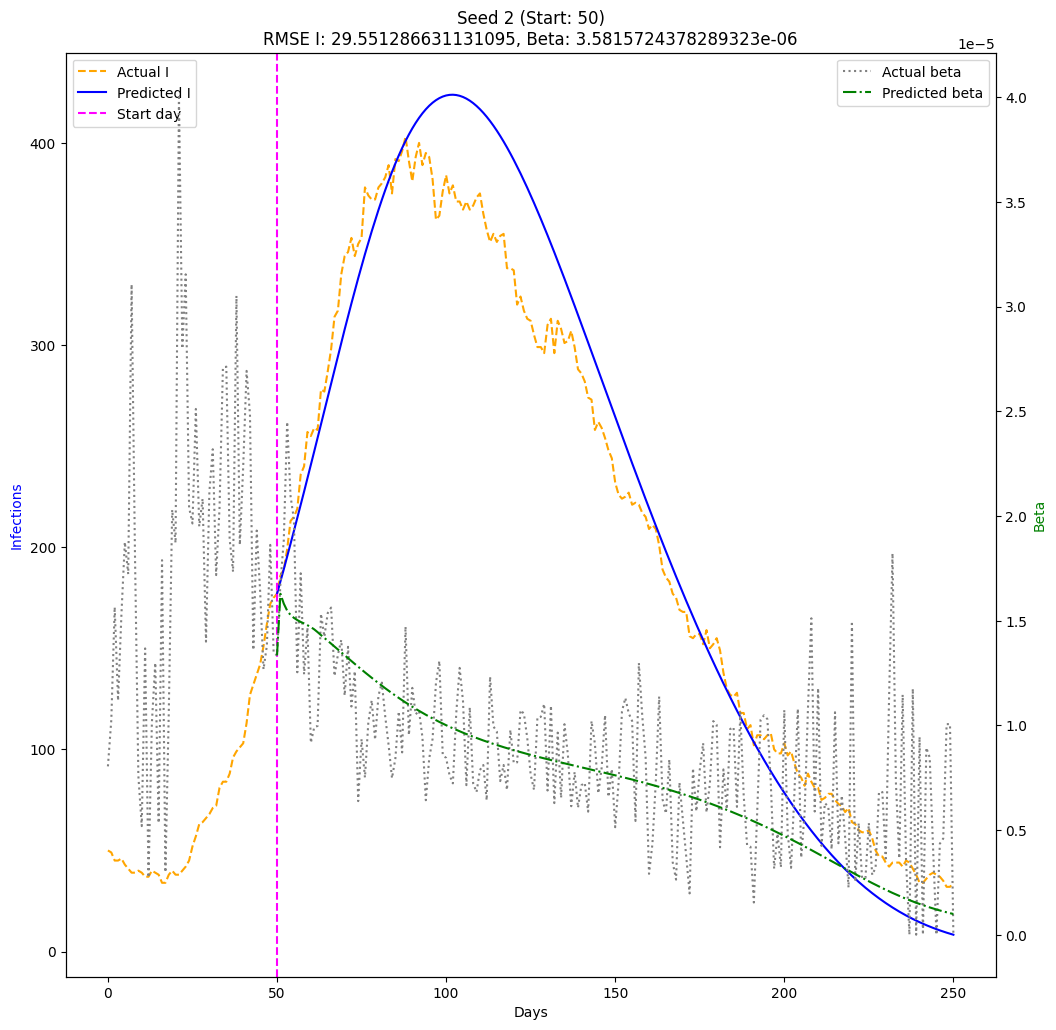

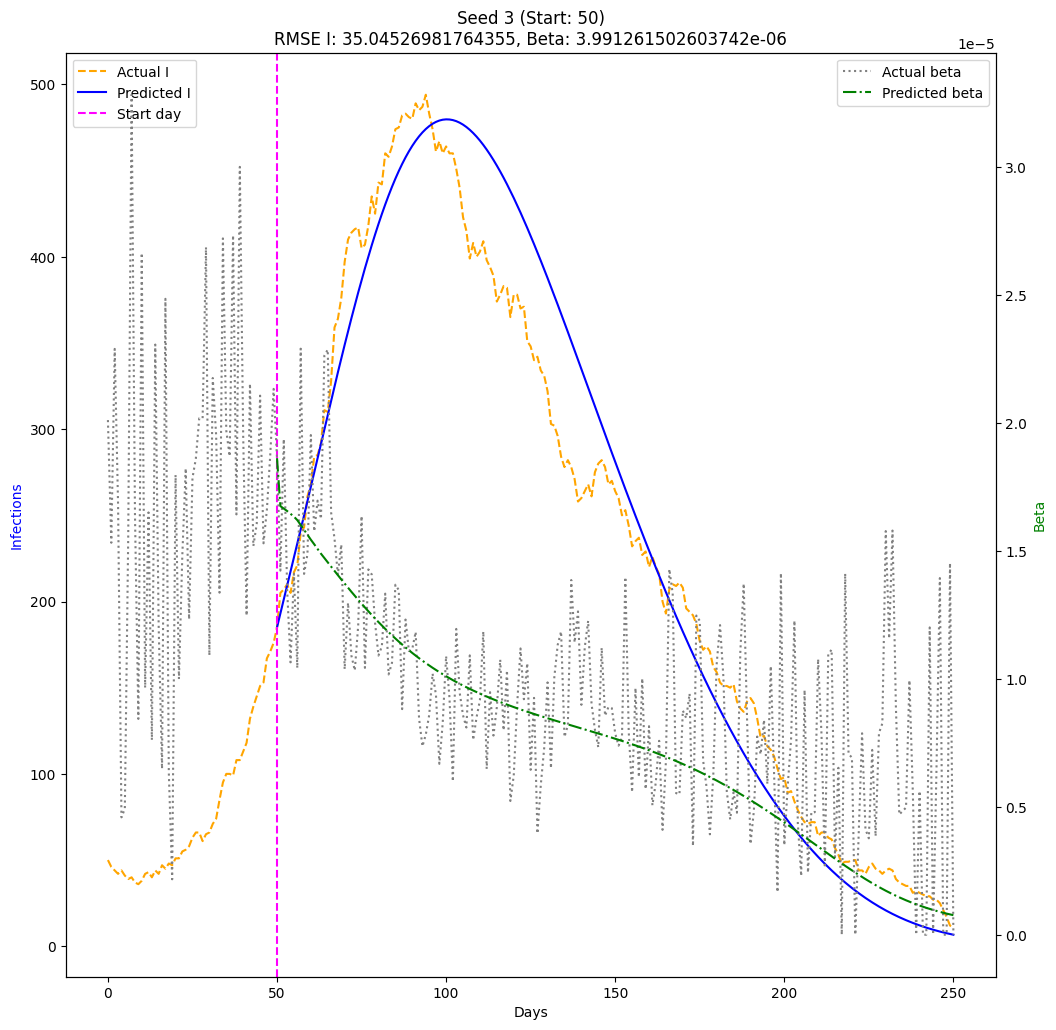

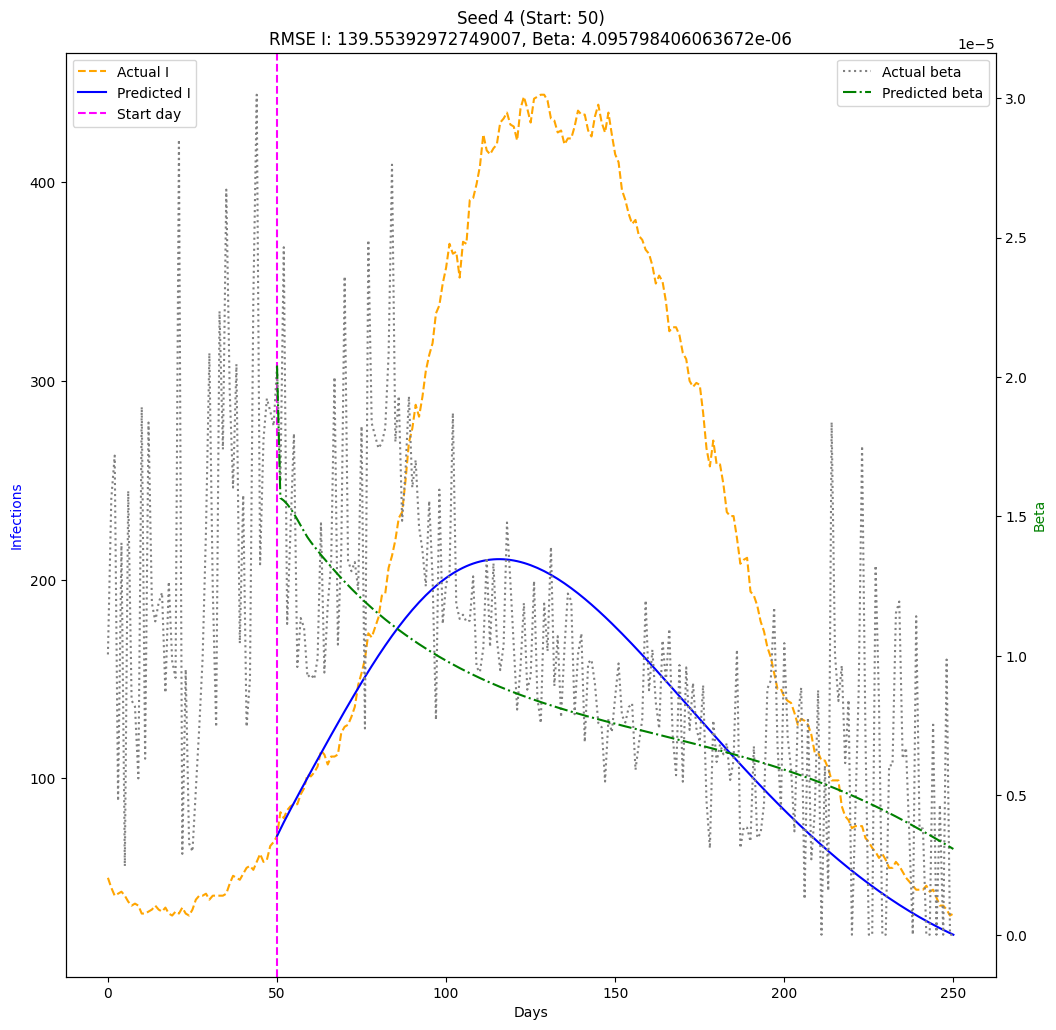

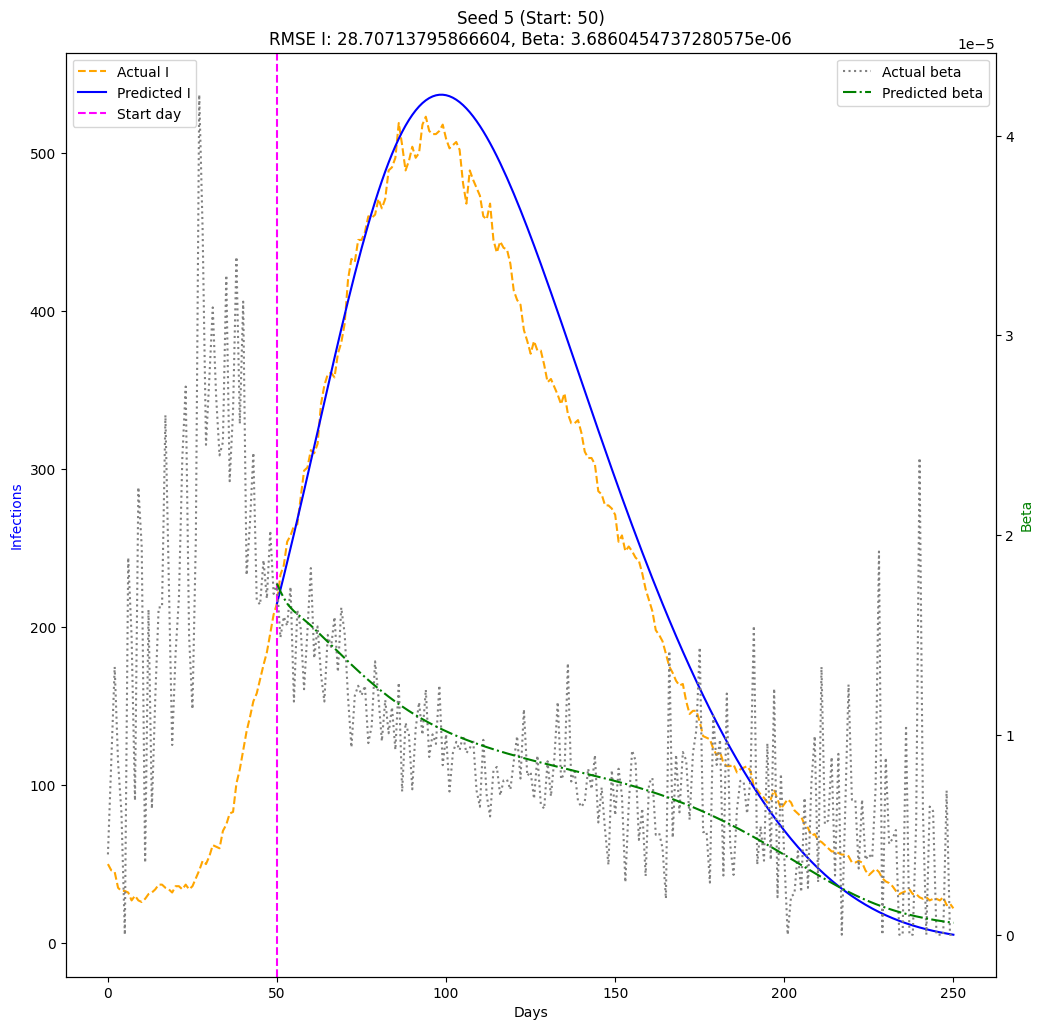

KeyboardInterrupt: 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from matplotlib.lines import Line2D

###############################################################################
# 1. Data preparation
###############################################################################
def create_sequences(data, window_size):
    """
    Convert a multivariate sequence into samples of shape (window_size, n_features).
    The target is the last column (log_beta).
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size, :-1])  # use first 6 features as input
        y.append(data[i + window_size, -1])         # predict normalized log_beta
    
    #X_df = pd.DataFrame(X[0], columns=['day', 'S', 'E', 'I', 'R', 'prev_I'])
        # add y[0] as last column
    #X_df['log_beta_target'] = y[0]
        # save as CSV
    #X_df.to_csv('first_sequence.csv', index=False)
    #print("X[0] and y[0] are saved in first_sequence.csv")
    return np.array(X), np.array(y)

def load_and_prepare_data(data_dir, num_seeds, window_size=7, test_seed=None):
    """
    Loads CSV files, applies shift(-2) for 'prev_I', computes log(Beta) for 'log_beta',
    and fits a global scaler on all 7 columns.
    Returns training sequences, targets, and the scaler.
    """
    all_data = []
    
    # First pass: collect data for scaling
    for i in range(num_seeds):
        if test_seed is not None and i == test_seed:
            continue
        try:
            df = pd.read_csv(os.path.join(data_dir, f'seir_seed_{i}.csv'))
            if i == 1:
                 print(df)
            df[['S', 'E', 'I', 'R', 'Beta']] = df[['S', 'E', 'I', 'R', 'Beta']].fillna(0)
            if 'day' not in df.columns:
                df['day'] = range(len(df))
            df['prev_I'] = df['I'].shift(-2).fillna(0)
            df['log_beta'] = np.log(df['Beta'].clip(lower=1e-7))
            features = df[['day', 'S', 'E', 'I', 'R', 'prev_I', 'log_beta']].values
            if i == 1:
                print(features)
            all_data.append(features)
        except Exception as e:
            print(f"Skipping seed {i}: {str(e)}")
            continue

    scaler = StandardScaler()
    if all_data:
        scaler.fit(np.concatenate(all_data))
    else:
        raise ValueError("No data collected for scaling. Please check your input files.")

    # Second pass: create training sequences
    all_X, all_y = [], []
    for i in range(num_seeds):
        if test_seed is not None and i == test_seed:
            continue
        try:
            df = pd.read_csv(os.path.join(data_dir, f'seir_seed_{i}.csv'))
            df[['S', 'E', 'I', 'R', 'Beta']] = df[['S', 'E', 'I', 'R', 'Beta']].fillna(0)
            if 'day' not in df.columns:
                df['day'] = range(len(df))
            df['prev_I'] = df['I'].shift(-2).fillna(0)
            df['log_beta'] = np.log(df['Beta'].clip(lower=1e-7))
            features = df[['day', 'S', 'E', 'I', 'R', 'prev_I', 'log_beta']].values
            scaled_features = scaler.transform(features)
            X, y = create_sequences(scaled_features, window_size)
            all_X.append(X)
            all_y.append(y)
        except Exception as e:
            print(f"Skipping seed {i}: {str(e)}")
            continue

    if not all_X or not all_y:
        raise ValueError("No valid training data found. Please check your input files.")

    return np.concatenate(all_X), np.concatenate(all_y), scaler

###############################################################################
# 2. Simplified model architecture with Grid search hyperparameters
###############################################################################
def build_lstm_model(window_size, n_features,
                     lstm_units1=64, lstm_units2=64,
                     dropout_rate1=0.2, dropout_rate2=0.3,
                     optimizer='rmsprop'):
    """
    Builds an LSTM model using the grid search best hyperparameters:
      - First LSTM layer units: 64 with recurrent dropout of 0.2
      - Second LSTM layer units: 64 with dropout of 0.3
      - Optimizer: rmsprop
    """
    inputs = Input(shape=(window_size, n_features))
    x = LSTM(lstm_units1, return_sequences=True, recurrent_dropout=dropout_rate1)(inputs)
    x = Dropout(dropout_rate1)(x)
    x = LSTM(lstm_units2, return_sequences=False)(x)
    x = Dropout(dropout_rate2)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='mse')
    return model

###############################################################################
# 3. Enhanced training configuration
###############################################################################
def lr_scheduler(epoch):
    """
    Applies learning rate decay after 20 epochs.
    """
    initial_lr = 0.001
    decay = 0.1 if epoch > 20 else 1.0
    return initial_lr * decay

def train_lstm_model(X_train, y_train, window_size=7):
    """
    Builds and trains the LSTM model with early stopping and a learning rate scheduler.
    """
    model = build_lstm_model(window_size, X_train.shape[2])
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop, LearningRateScheduler(lr_scheduler)],
        verbose=1
    )
    return model, history

###############################################################################
# 4. Simulation components
###############################################################################
class LSTMPredictor:
    """
    Wraps the trained LSTM model to predict beta on a rolling window of
    [day, S, E, I, R, prev_I] (6 features). 
    The model was trained to predict normalized log_beta, so this class
    denormalizes the prediction and returns beta.
    """
    def __init__(self, model, full_scaler, window_size=7):
        self.model = model
        # Create a scaler for input features (first 6 columns)
        self.input_scaler = StandardScaler()
        self.input_scaler.mean_ = full_scaler.mean_[:6]
        self.input_scaler.scale_ = full_scaler.scale_[:6]
        self.input_scaler.var_ = full_scaler.var_[:6]
        self.input_scaler.n_features_in_ = 6
        self.window_size = window_size
        self.buffer = []
        # Store target parameters for log_beta (7th column)
        self.target_mean = full_scaler.mean_[-1]
        self.target_scale = full_scaler.scale_[-1]
        
    def update_buffer(self, new_data):
        # new_data should be a list with 6 elements: [day, S, E, I, R, prev_I]
        self.buffer.append(new_data)
        if len(self.buffer) > self.window_size:
            self.buffer.pop(0)
            
    def predict_next(self):
        # Ensure the buffer has window_size rows
        if len(self.buffer) < self.window_size:
            padded = np.zeros((self.window_size, 6))
            padded[-len(self.buffer):] = self.buffer
        else:
            padded = np.array(self.buffer[-self.window_size:])
            
        scaled = self.input_scaler.transform(padded)
        scaled_window = scaled.reshape(1, self.window_size, 6)
        normalized_pred = self.model.predict(scaled_window, verbose=0)[0][0]
        # Denormalize to obtain the raw log_beta
        raw_log_beta = normalized_pred * self.target_scale + self.target_mean
        # Compute beta by exponentiating the log_beta
        predicted_beta = np.exp(raw_log_beta)
        return predicted_beta

def simulate_seir_lstm(seed_data, start_day, predictor, max_days=200, stop_early=True):
    """
    Simulates the SEIR model from start_day onward using predicted beta.
    """
    # Initial conditions at start_day
    initial = seed_data.iloc[start_day]
    S, E, I, R, Beta = initial[['S', 'E', 'I', 'R', 'Beta']]
    
    gamma = 0.08
    sigma = 0.1
    
    # Initialize predictor buffer using the last 'window_size' days
    for i in range(max(0, start_day - predictor.window_size + 1), start_day + 1):
        row = seed_data.iloc[i]
        raw_features = [row['day'], row['S'], row['E'], row['I'], row['R'], row['prev_I']]
        predictor.update_buffer(raw_features)
    
    history = {
        'days': [start_day],
        'S': [S],
        'E': [E],
        'I': [I],
        'R': [R],
        'Beta': [Beta]
    }
    
    for day in range(1, max_days + 1):
        current_day = start_day + day
        
        # Predict beta (this prediction already inverts the normalization)
        predicted_beta = predictor.predict_next()
        
        # SEIR update equations
        new_exposed = predicted_beta * S * I
        new_infectious = sigma * E
        new_recoveries = gamma * I
        
        S = max(S - new_exposed, 0)
        E = max(E + new_exposed - new_infectious, 0)
        I = max(I + new_infectious - new_recoveries, 0)
        R = max(R + new_recoveries, 0)
        
        # Update the predictor buffer with the new state (use previous I as a proxy for prev_I)
        prev_I = history['I'][-1]
        predictor.update_buffer([current_day, S, E, I, R, prev_I])
        
        history['days'].append(current_day)
        history['S'].append(S)
        history['E'].append(E)
        history['I'].append(I)
        history['R'].append(R)
        history['Beta'].append(predicted_beta)
        
        # Optionally stop early if the disease nearly dies out
        if stop_early and I < 1e-7 and E < 1e-7:
            break
            
    return history

###############################################################################
# 5. Training pipeline
###############################################################################
def train_and_save_model(data_dir, num_seeds, model_save_path, scaler_save_path, window_size=7):
    print(f"Training LSTM model on {num_seeds} seeds...")
    start_time = time.time()
    
    X, y, scaler = load_and_prepare_data(data_dir, num_seeds, window_size)
    if len(X) == 0:
        raise ValueError("No valid training data found.")
    
    model, history = train_lstm_model(X, y, window_size)
    
    model.save(model_save_path)
    joblib.dump(scaler, scaler_save_path)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f}s")
    
    # Plot training history
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, training_time

###############################################################################
# 6. Prediction and evaluation
###############################################################################
def predict_multiple_seeds(seeds, start_day, data_dir, model_path, scaler_path, window_size):
    """
    Loads the model and scaler, simulates from 'start_day' for each seed,
    plots actual vs. predicted data, and computes RMSE for I and Beta.
    """
    model = load_model(model_path)
    full_scaler = joblib.load(scaler_path)
    predictor = LSTMPredictor(model, full_scaler, window_size=window_size)
    
    results = []
    for seed in seeds:
        try:
            df = pd.read_csv(os.path.join(data_dir, f'seir_seed_{seed}.csv'))
            df[['S', 'E', 'I', 'R', 'Beta']] = df[['S', 'E', 'I', 'R', 'Beta']].fillna(0)
            if 'day' not in df.columns:
                df['day'] = range(len(df))
            df['prev_I'] = df['I'].shift(-2).fillna(0)
            
            history = simulate_seir_lstm(df, start_day, predictor)
            
            sim_length = len(history['I'])
            end_day = min(start_day + sim_length, len(df))
            
            actual_I = df['I'].iloc[start_day:end_day].values
            actual_Beta = df['Beta'].iloc[start_day:end_day].values
            pred_I = history['I'][: (end_day - start_day)]
            pred_Beta = history['Beta'][: (end_day - start_day)]
            
            rmse_I = np.sqrt(mean_squared_error(actual_I, pred_I)) if len(actual_I) > 0 else np.nan
            rmse_Beta = np.sqrt(mean_squared_error(actual_Beta, pred_Beta)) if len(actual_Beta) > 0 else np.nan
            
            # Plot the results
            fig, ax1 = plt.subplots(figsize=(12,12))
            ax2 = ax1.twinx()
            
            ax1.plot(df['day'], df['I'], '--', color='orange', label='Actual I')
            ax2.plot(df['day'], df['Beta'], ':', color='grey', label='Actual beta')
            ax1.plot(history['days'], history['I'], '-', color='blue', label='Predicted I')
            ax2.plot(history['days'], history['Beta'], '-.', color='green', label='Predicted beta')
            ax1.axvline(start_day, color='magenta', linestyle='--', label='Start day')
            
            ax1.set_xlabel('Days')
            ax1.set_ylabel('Infections', color='blue')
            ax2.set_ylabel('Beta', color='green')
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper right')
            
            title_str = f"Seed {seed} (Start: {start_day})\nRMSE I: {rmse_I}, Beta: {rmse_Beta}"
            plt.title(title_str)
            plt.show()
            
            results.append({
                'seed': seed,
                'rmse_I': rmse_I,
                'rmse_Beta': rmse_Beta,
                'pred_length': len(pred_I)
            })
        except Exception as e:
            print(f"Error processing seed {seed}: {str(e)}")
            results.append({'seed': seed, 'error': str(e)})
    
    return pd.DataFrame(results)

###############################################################################
# 7. Grid plotting function for multiple seeds
###############################################################################
def plot_results(seed_data, history, start_day, seed, ax):
    """
    Plots simulation results on a given axis and returns RMSE for I and Beta.
    """
    ax2 = ax.twinx()
    ax.plot(seed_data['day'], seed_data['I'], '--', color='orange', label='Actual I')
    ax.plot(history['days'], history['I'], '-', color='blue', label='Predicted I')
    ax.axvline(start_day, color='purple', linestyle='--', label='Start Day')
    ax2.plot(seed_data['day'], seed_data['Beta'], ':', color='grey', label='Actual beta')
    ax2.plot(history['days'], history['Beta'], '-.', color='green', label='Predicted beta')
    ax.set_xlabel('Days')
    ax.set_ylabel('Infections', color='blue')
    ax2.set_ylabel('Beta', color='green')
    
    sim_length = len(history['I'])
    end_day = min(start_day + sim_length, len(seed_data))
    actual_I = seed_data['I'].iloc[start_day:end_day].values
    actual_Beta = seed_data['Beta'].iloc[start_day:end_day].values
    pred_I = history['I'][: (end_day - start_day)]
    pred_Beta = history['Beta'][: (end_day - start_day)]
    rmse_I = np.sqrt(mean_squared_error(actual_I, pred_I)) if len(actual_I) > 0 else np.nan
    rmse_Beta = np.sqrt(mean_squared_error(actual_Beta, pred_Beta)) if len(actual_Beta) > 0 else np.nan
    ax.set_title(f"Seed {seed}\nRMSE I: {rmse_I:.2f}, Beta: {rmse_Beta:.2f}")
    return rmse_I, rmse_Beta

def plot_simulation_grid(seeds, start_day, data_dir, model, scaler, window_size):
    num_windows = math.ceil(len(seeds) / 10)
    results_list = []
    all_rmse_I = []
    all_rmse_Beta = []
    
    # Create predictor from the given model and scaler
    predictor = LSTMPredictor(model, scaler, window_size=window_size)
    
    for window in range(num_windows):
        window_seeds = seeds[window*10 : (window+1)*10]
        fig, axes = plt.subplots(5, 2, figsize=(12, 12))
        plt.subplots_adjust(hspace=0.4, wspace=0.5)
        axes = axes.flatten()
        
        for idx, seed in enumerate(window_seeds):
            ax = axes[idx]
            seed_result = {'seed': seed, 'start_day': start_day}
            seed_start_time = time.time()
            try:
                file_path = os.path.join(data_dir, f'seir_seed_{seed}.csv')
                seed_data = pd.read_csv(file_path)
                seed_data[['S', 'E', 'I', 'R', 'Beta']] = seed_data[['S', 'E', 'I', 'R', 'Beta']].fillna(0)
                seed_data['day'] = np.arange(len(seed_data))
                seed_data['prev_I'] = seed_data['I'].shift(-2).fillna(0)
                
                if start_day >= len(seed_data):
                    print(f"Skipping seed {seed} - insufficient data")
                    seed_result['error'] = 'insufficient data'
                    results_list.append(seed_result)
                    ax.axis('off')
                    continue
                
                # Simulate the SEIR model
                history = simulate_seir_lstm(seed_data, start_day, predictor, max_days=200, stop_early=False)
                # Compute peak infection and day
                peak_I = max(history['I'])
                peak_day = history['days'][np.argmax(history['I'])]
                simulation_time = time.time() - seed_start_time
                seed_result['peak_day'] = peak_day
                seed_result['peak_I'] = peak_I
                seed_result['simulation_time_seconds'] = simulation_time
                
                rmse_I, rmse_Beta = plot_results(seed_data, history, start_day, seed, ax)
                seed_result['rmse_I'] = rmse_I
                seed_result['rmse_Beta'] = rmse_Beta
                results_list.append(seed_result)
                
                all_rmse_I.append(rmse_I)
                all_rmse_Beta.append(rmse_Beta)
                
            except Exception as e:
                print(f"Error processing seed {seed}: {str(e)}")
                seed_result['error'] = str(e)
                results_list.append(seed_result)
                ax.axis('off')
        
        # Turn off any unused subplots
        for j in range(len(window_seeds), len(axes)):
            axes[j].axis('off')
        
        # Create a custom legend
        legend_elements = [
            Line2D([0], [0], color='orange', linestyle='--', label='Actual Infections'),
            Line2D([0], [0], color='blue', linestyle='-', label='Predicted Infections'),
            Line2D([0], [0], color='purple', linestyle='--', label='Start Day'),
            Line2D([0], [0], color='grey', linestyle=':', label='Actual Beta'),
            Line2D([0], [0], color='green', linestyle='-.', label='Predicted Beta'),
        ]
        fig.legend(handles=legend_elements, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))
        fig.suptitle(f"Seeds {window*10 + 1} to {(window+1)*10}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
    
    return results_list, all_rmse_I, all_rmse_Beta

###############################################################################
# Main execution
###############################################################################
if __name__ == "__main__":
    # Configuration
    DATA_DIR = f'train_data/'
    TEST_DATA_DIR = f'seir_30_seeds_v0/'
    MODEL_PATH = 'seir_lstm_model_rmsprop.keras'
    SCALER_PATH = 'lstm_scaler.pkl'
    
    WINDOW_SIZE = 14   # Must be the same for training and simulation
    NUM_SEEDS = 1500   # Number of CSV files to train on
    TEST_SEEDS = list(range(10))  # Seeds to test/evaluate
    START_DAY = 50     # Simulation start day
    
    # 1) Train and save the model
    '''
    COMMENT THIS PART IF THERE IS NO NEED TO TRAIN AND SAVE THE MODEL
    '''
    model, scaler, _ = train_and_save_model(
        DATA_DIR, 
        num_seeds=NUM_SEEDS, 
        model_save_path=MODEL_PATH, 
        scaler_save_path=SCALER_PATH, 
        window_size=WINDOW_SIZE
    )
    
    # 2) Evaluate on test seeds, starting from START_DAY
    '''
    COMMENT THIS PART IF THERE IS NO NEED TO SEPARATELY PLOT EACH SEED
    '''
    results_df = predict_multiple_seeds(
        seeds=TEST_SEEDS,
        start_day=START_DAY,
        data_dir=TEST_DATA_DIR,
        model_path=MODEL_PATH,
        scaler_path=SCALER_PATH,
        window_size=WINDOW_SIZE
    )
    results_df.to_csv('lstm_predictions_rmsprop.csv', index=False)
    print(results_df.describe())
    
    # 3) Plot simulation grid for multiple seeds
    '''
    COMMENT THIS PART IF THERE IS NO NEED TO PLOT 10 SEEDS PER WINDOW
    '''
    model = load_model(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    grid_results, grid_rmse_I, grid_rmse_Beta = plot_simulation_grid(
        seeds=TEST_SEEDS,
        start_day=START_DAY,
        data_dir=TEST_DATA_DIR,
        model=model,
        scaler=scaler,
        window_size=WINDOW_SIZE
    )
